# We are assembling all elements of figure 2 of the TwinC paper in this notebook. 

In [1]:
import sys
sys.path.append("../../twinc")

import os
import gzip
import torch
import cooler
import pyBigWig
import hicstraw
import argparse
import matplotlib
import numpy as np
import seaborn as sns
import _pickle as pickle
from scipy.stats import gmean
import matplotlib.pyplot as plt
from twinc_data import TransContacts
from scipy.stats import pearsonr, spearmanr
from matplotlib.colors import ListedColormap
from sklearn.metrics import roc_curve, roc_auc_score

if not os.path.exists(f"../../figures"):
    os.system(f"mkdir ../../figures")
else:
    print(f"figures directory exists")

if not os.path.exists(f"../../figures/classification_accuracy"):
    os.system(f"mkdir ../../figures/classification_accuracy")
else:
    print(f"classification_accuracy figures directory exists")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# 1. ROC Curve for the GM12878 In situ Hi-C test set across five cross-validation folds.  

chr1 chr3
test_results_pos_pos: ['hic_sum', 'hic_sum_noartifacts', 'hic_pos_num_sup', 'hic_neg_num_sup', 'pred_matrix_pos', 'pred_matrix_neg', 'true_matrix', 'pred_matrix', 'pred_matrix_gc']
0.7969664489200656
chr2 chr6
test_results_pos_pos: ['hic_sum', 'hic_sum_noartifacts', 'hic_pos_num_sup', 'hic_neg_num_sup', 'pred_matrix_pos', 'pred_matrix_neg', 'true_matrix', 'pred_matrix', 'pred_matrix_gc']
0.7834584867867916
chr5 chr7
test_results_pos_pos: ['hic_sum', 'hic_sum_noartifacts', 'hic_pos_num_sup', 'hic_neg_num_sup', 'pred_matrix_pos', 'pred_matrix_neg', 'true_matrix', 'pred_matrix', 'pred_matrix_gc']
0.7677164811880859
chr9 chr10
test_results_pos_pos: ['hic_sum', 'hic_sum_noartifacts', 'hic_pos_num_sup', 'hic_neg_num_sup', 'pred_matrix_pos', 'pred_matrix_neg', 'true_matrix', 'pred_matrix', 'pred_matrix_gc']
0.768616641073109
chr14 chr18
test_results_pos_pos: ['hic_sum', 'hic_sum_noartifacts', 'hic_pos_num_sup', 'hic_neg_num_sup', 'pred_matrix_pos', 'pred_matrix_neg', 'true_matrix', 

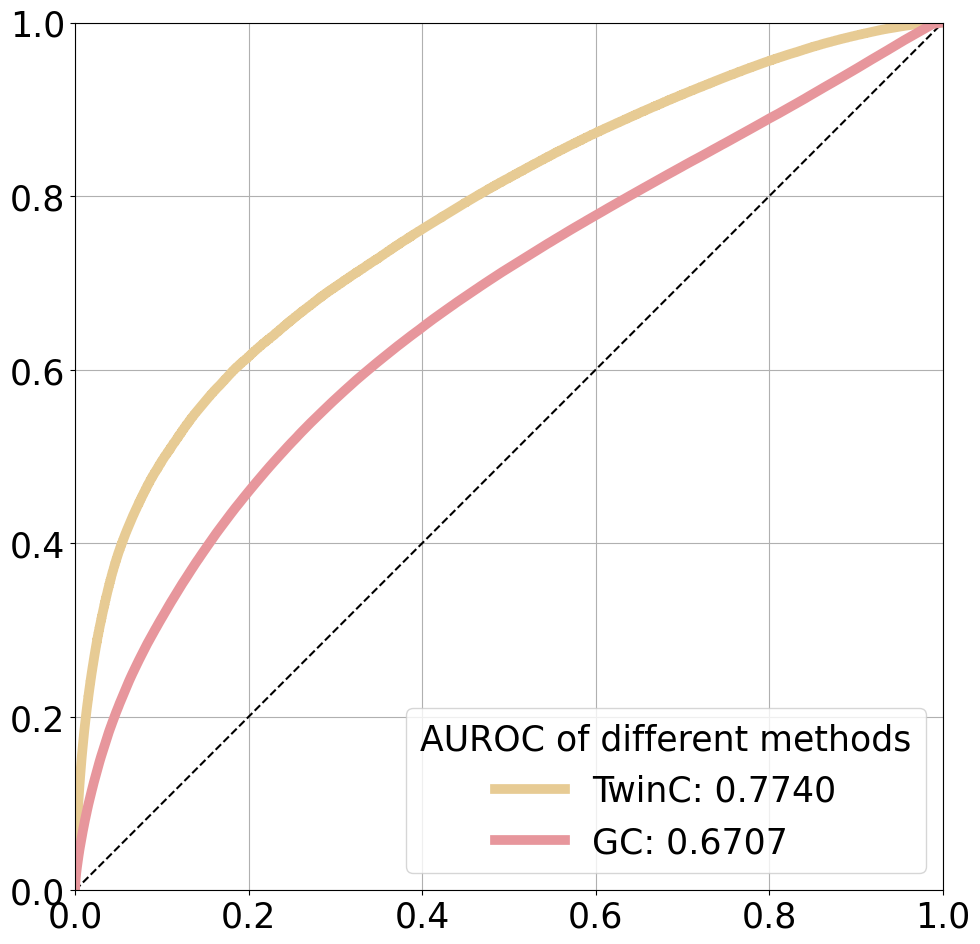

In [5]:
chr_combs = [['chr1', 'chr3'], ['chr2', 'chr6'], ['chr5', 'chr7'], ['chr9', 'chr10'], ['chr14', 'chr18']]
all_true = []
all_pred = []
all_pred_gc = []
for chrA, chrB in chr_combs: 
    print(chrA, chrB)
    test_results_pos_pos = np.load(f"../../results/common_matrix_gm12878_preds///{chrA}_{chrB}_test_results.npz")
    print(f"test_results_pos_pos: {list(test_results_pos_pos.keys())}")

    hic_sum_noartifacts = test_results_pos_pos["hic_sum"]
    hic_pos_num_sup = test_results_pos_pos["hic_pos_num_sup"]
    hic_neg_num_sup = test_results_pos_pos["hic_neg_num_sup"]
    pred_matrix = test_results_pos_pos["pred_matrix_pos"]
    pred_matrix_gc = test_results_pos_pos["pred_matrix_gc"]

    true_matrix = np.zeros((hic_pos_num_sup.shape))
    true_matrix[:, :] = np.nan

    true_matrix[hic_pos_num_sup==1] = 1
    true_matrix[hic_neg_num_sup==1] = 0

    valid = np.isfinite(true_matrix)

    all_true.extend(true_matrix[valid].flatten())
    all_pred.extend(pred_matrix[valid].flatten())
    all_pred_gc.extend(pred_matrix_gc[valid].flatten())
    print(roc_auc_score(all_true, all_pred))

SMALL_SIZE = 25
MEDIUM_SIZE = 30
BIGGER_SIZE = 35

plt.rcParams['axes.facecolor']='white'
plt.rc('font', size=SMALL_SIZE)          
plt.rc('axes', titlesize=SMALL_SIZE)    
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# select a color palette
cmap = matplotlib.cm.get_cmap('tab20b')
colors = [cmap(3), cmap(11), cmap(15)]
figure, axis = plt.subplots(1, 1, figsize=(17, 10))
axis.plot([0, 1.0], [0, 1.0], "k--")

axis.grid(True)
fpr, tpr, thresholds = roc_curve(all_true, all_pred, pos_label=1)
twincnn_auroc = roc_auc_score(all_true, all_pred)
axis.plot(fpr, tpr, linewidth=7.0, label=f"TwinC: {twincnn_auroc:0.4f}", color=colors[1])

fpr, tpr, thresholds = roc_curve(all_true, all_pred_gc, pos_label=1)
gc_auroc = roc_auc_score(all_true, all_pred_gc)
axis.plot(fpr, tpr, linewidth=7.0, label=f"GC: {gc_auroc:0.4f}", color=colors[2])

axis.set_aspect('equal', adjustable='box')
axis.set_xlim([0, 1.0])
axis.set_ylim([0, 1.0])
plt.legend(title="AUROC of different methods", loc='lower right')
plt.tight_layout()
plt.savefig(f"../../figures/classification_accuracy/test_roc_gm12878.pdf", transparent=True) 
plt.show()


# 2. ROC Curve when using DNA SPRITE as labels 

chr1 chr3
test_results_pos_pos: ['hic_sum', 'hic_sum_noartifacts', 'hic_pos_num_sup', 'hic_neg_num_sup', 'pred_matrix_pos', 'pred_matrix_neg', 'true_matrix', 'pred_matrix', 'pred_matrix_gc']
0.9809889676910952
chr2 chr6
test_results_pos_pos: ['hic_sum', 'hic_sum_noartifacts', 'hic_pos_num_sup', 'hic_neg_num_sup', 'pred_matrix_pos', 'pred_matrix_neg', 'true_matrix', 'pred_matrix', 'pred_matrix_gc']
0.956512459161952
chr5 chr7
test_results_pos_pos: ['hic_sum', 'hic_sum_noartifacts', 'hic_pos_num_sup', 'hic_neg_num_sup', 'pred_matrix_pos', 'pred_matrix_neg', 'true_matrix', 'pred_matrix', 'pred_matrix_gc']
0.9213674715049333
chr9 chr10
test_results_pos_pos: ['hic_sum', 'hic_sum_noartifacts', 'hic_pos_num_sup', 'hic_neg_num_sup', 'pred_matrix_pos', 'pred_matrix_neg', 'true_matrix', 'pred_matrix', 'pred_matrix_gc']
0.9270964778800475
chr14 chr18
test_results_pos_pos: ['hic_sum', 'hic_sum_noartifacts', 'hic_pos_num_sup', 'hic_neg_num_sup', 'pred_matrix_pos', 'pred_matrix_neg', 'true_matrix', 

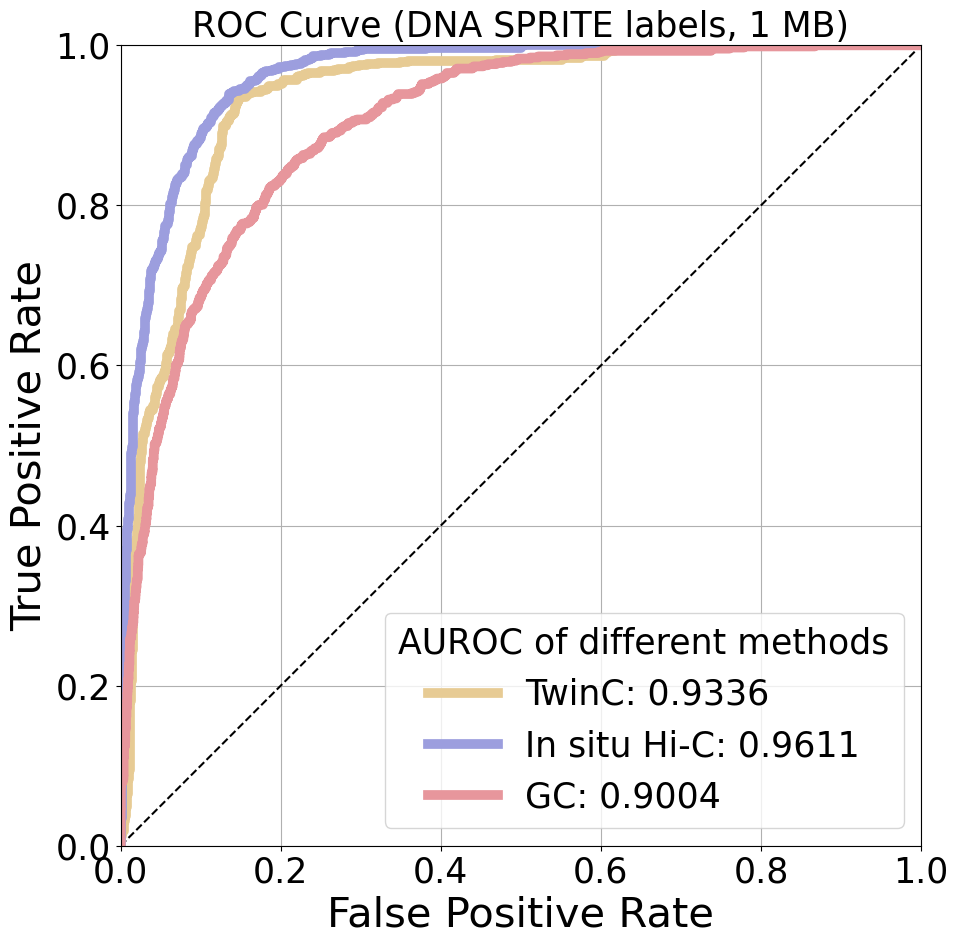

In [7]:
def summary_patches(matrix, patch_size, type_summary="max"):
    """
    Computes the q-th quantile for non-overlapping patches of size (patch_size x patch_size).
    Handles edges by allowing smaller patches at the borders.
    :param: matrix: np.ndarray, 2D input array.
    :param: patch_size: int, Size of the square patch.
     return: np.ndarray, 2D array of patch quantiles.
    """
    h, w = matrix.shape
    num_blocks_y = int((h + patch_size - 1) // patch_size)
    num_blocks_x = int((w + patch_size - 1) // patch_size)

    result = np.zeros((num_blocks_y, num_blocks_x))

    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            y_start = i * patch_size
            y_end = min((i + 1) * patch_size, h)
            x_start = j * patch_size
            x_end = min((j + 1) * patch_size, w)

            patch = matrix[y_start:y_end, x_start:x_end]
            if type_summary == "max":
                result[i, j] = np.max(patch)
            elif type_summary == "min":
                result[i, j] = np.min(patch)
            elif type_summary == "sum":
                result[i, j] = np.sum(patch)
            elif type_summary == "mean":
                result[i, j] = np.mean(patch)
    return result


chr_combs = [['chr1', 'chr3'], ['chr2', 'chr6'], ['chr5', 'chr7'], ['chr9', 'chr10'], ['chr14', 'chr18']]
all_true = []
all_pred = []
all_pred_in_situ = []
all_pred_gc = []
total_pos = 0
total_neg = 0
for chrA, chrB in chr_combs: 
    sprite = f"../../results/common_matrix_gm12878_DNA_SPRITE/{chrA}_{chrB}_GM12878_DNASPRITE_1000000_5_v_5.gz"

    sprite_pkl = pickle.load(gzip.open(sprite, 'rb'))
    
    pos = np.zeros((sprite_pkl.hic_pos_num_sup.shape))
    neg = np.zeros((sprite_pkl.hic_pos_num_sup.shape))
    pos[:, :] = np.where(sprite_pkl.hic_sum_noartifacts>=55, 1, 0)
    neg[:, :] = np.where(sprite_pkl.hic_sum_noartifacts<=15, 1, 0)

    true_matrix = np.zeros((sprite_pkl.hic_pos_num_sup.shape))
    true_matrix[pos==0] = np.nan
    true_matrix[neg==0] = np.nan
    true_matrix[pos==1] = 1
    true_matrix[neg==1] = 0
    true_matrix[np.isnan(sprite_pkl.hic_sum_noartifacts)] = np.nan
    
    total_pos += np.nansum(true_matrix==1)
    total_neg += np.nansum(true_matrix==0)

    in_situ = f"../../results/common_matrix_gm12878_IN_SITU_HiC/{chrA}_{chrB}_GM12878_1000000_5_v_5.gz"

    in_situ_pkl = pickle.load(gzip.open(in_situ, 'rb'))
    hic_sum_noartifacts = in_situ_pkl.hic_sum
    
    print(chrA, chrB)
    test_results_pos_pos = np.load(f"../../results/common_matrix_gm12878_preds///{chrA}_{chrB}_test_results.npz")
    print(f"test_results_pos_pos: {list(test_results_pos_pos.keys())}")

    pred_matrix = test_results_pos_pos["pred_matrix_pos"]
    pred_matrix = summary_patches(pred_matrix, patch_size=10, type_summary="min")

    pred_matrix_gc = test_results_pos_pos["pred_matrix_gc"]
    pred_matrix_gc = summary_patches(pred_matrix_gc, patch_size=10, type_summary="min")

    valid = np.isfinite(true_matrix)

    all_true.extend(true_matrix[valid].flatten())
    all_pred.extend(pred_matrix[valid].flatten())
    all_pred_gc.extend(pred_matrix_gc[valid].flatten())
    all_pred_in_situ.extend(hic_sum_noartifacts[valid].flatten())
    print(roc_auc_score(all_true, all_pred))

SMALL_SIZE = 25
MEDIUM_SIZE = 30
BIGGER_SIZE = 35

plt.rcParams['axes.facecolor']='white'
plt.rc('font', size=SMALL_SIZE)          
plt.rc('axes', titlesize=SMALL_SIZE)    
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# select a color palette
cmap = matplotlib.cm.get_cmap('tab20b')
colors = [cmap(3), cmap(11), cmap(15)]
figure, axis = plt.subplots(1, 1, figsize=(17, 10))
axis.plot([0, 1.0], [0, 1.0], "k--")

axis.grid(True)
fpr, tpr, thresholds = roc_curve(all_true, all_pred, pos_label=1)
twincnn_auroc = roc_auc_score(all_true, all_pred)
axis.plot(fpr, tpr, linewidth=7.0, label=f"TwinC: {twincnn_auroc:0.4f}", color=colors[1])

fpr, tpr, thresholds = roc_curve(all_true, all_pred_in_situ, pos_label=1)
in_situ_auroc = roc_auc_score(all_true, all_pred_in_situ)
axis.plot(fpr, tpr, linewidth=7.0, label=f"In situ Hi-C: {in_situ_auroc:0.4f}", color=colors[0])

fpr, tpr, thresholds = roc_curve(all_true, all_pred_gc, pos_label=1)
gc_auroc = roc_auc_score(all_true, all_pred_gc)
axis.plot(fpr, tpr, linewidth=7.0, label=f"GC: {gc_auroc:0.4f}", color=colors[2])

axis.set_aspect('equal', adjustable='box')
axis.set_xlim([0, 1.0])
axis.set_ylim([0, 1.0])
axis.set_xlabel("False Positive Rate")
axis.set_ylabel("True Positive Rate")
axis.set_title("ROC Curve (DNA SPRITE labels, 1 MB)")
plt.legend(title="AUROC of different methods", loc='lower right')
plt.tight_layout()
plt.savefig(f"../../figures/classification_accuracy/roc_curve_GM12878_dna_sprite_twinc_in_situ_comparison.pdf", transparent=True) 
plt.show()